# Part 1: Extracting a Journal's Publications+Researchers Datasets

In this notebook we are going to 

* extract all publications data for a given journal
* have a quick look at the publications' authors and affiliations 
* review how many authors have been disambiguated with a Dimensions Researcher ID
* produce a dataset of non-disambiguated authors that can be used for manual disambiguation 

## Prerequisites: Installing the Dimensions Library and Logging in

In [18]:

# @markdown # Get the API library and login
# @markdown Click the 'play' button on the left (or shift+enter) after entering your API credentials

username = "" #@param {type: "string"}
password = "" #@param {type: "string"}
endpoint = "https://app.dimensions.ai" #@param {type: "string"}


!pip install dimcli plotly tqdm -U --quiet
import dimcli
from dimcli.shortcuts import *
dimcli.login(username, password, endpoint)
dsl = dimcli.Dsl()

#
# load common libraries
import time
import sys
import json
import os
import pandas as pd
from pandas.io.json import json_normalize
from tqdm.notebook import tqdm as progress

#
# charts libs
# import plotly_express as px
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#
# create output data folder
if not(os.path.exists("data")):
    os.mkdir("data")

DimCli v0.6.7 - Succesfully connected to <https://app.dimensions.ai> (method: dsl.ini file)


## Selecting a Journal and Extracting All Publications Metadata

In [2]:
#@title Select a journal from the dropdown
#@markdown If the journal isn't there, you can try type in the exact name instead.

journal_title = "Nature Genetics" #@param ['Nature', 'The Science of Nature', 'Nature Communications', 'Nature Biotechnology', 'Nature Medicine', 'Nature Genetics', 'Nature Neuroscience', 'Nature Structural & Molecular Biology', 'Nature Methods', 'Nature Cell Biology', 'Nature Immunology', 'Nature Reviews Drug Discovery', 'Nature Materials', 'Nature Physics', 'Nature Reviews Neuroscience', 'Nature Nanotechnology', 'Nature Reviews Genetics', 'Nature Reviews Urology', 'Nature Reviews Molecular Cell Biology', 'Nature Precedings', 'Nature Reviews Cancer', 'Nature Photonics', 'Nature Reviews Immunology', 'Nature Reviews Cardiology', 'Nature Reviews Gastroenterology & Hepatology', 'Nature Reviews Clinical Oncology', 'Nature Reviews Endocrinology', 'Nature Reviews Neurology', 'Nature Chemical Biology', 'Nature Reviews Microbiology', 'Nature Geoscience', 'Nature Reviews Rheumatology', 'Nature Climate Change', 'Nature Reviews Nephrology', 'Nature Chemistry', 'Nature Digest', 'Nature Protocols', 'Nature Middle East', 'Nature India', 'Nature China', 'Nature Plants', 'Nature Microbiology', 'Nature Ecology & Evolution', 'Nature Astronomy', 'Nature Energy', 'Nature Human Behaviour', 'AfCS-Nature Molecule Pages', 'Human Nature', 'Nature Reviews Disease Primers', 'Nature Biomedical Engineering', 'Nature Reports Stem Cells', 'Nature Reviews Materials', 'Nature Sustainability', 'Nature Catalysis', 'Nature Electronics', 'Nature Reviews Chemistry', 'Nature Metabolism', 'Nature Reviews Physics', 'Nature Machine Intelligence', 'NCI Nature Pathway Interaction Database', 'Nature Reports: Climate Change'] {allow-input: true}
start_year = 2015  #@param {type: "number"}
#@markdown ---

# PS 
# To get titles from the API one can do this:
# > %dsldf search publications where journal.title~"Nature" and publisher="Springer Nature" return journal limit 100
# > ", ".join([f"'{x}'" for x in list(dsl_last_results.title)]) 
#

q_template = """search publications where 
    journal.title="{}" and 
    year>={} 
    return publications[basics+altmetric+times_cited]"""
q = q_template.format(journal_title, start_year)
print("DSL Query:\n----\n", q, "\n----")
pubs = dsl.query_iterative(q.format(journal_title, start_year), limit=500)


DSL Query:
----
 search publications where 
    journal.title="Nature Genetics" and 
    year>=2015 
    return publications[basics+altmetric+times_cited] 
----
500 / 1472
1000 / 1472
1472 / 1472


Save the data as a CSV file in case we want to reuse it later

In [3]:
dfpubs = pubs.as_dataframe()
dfpubs.to_csv("data/1.pubs_metadata_with_metrics.csv")
# preview the publications 
dfpubs.head(10)

,pages,altmetric,year,id,times_cited,author_affiliations,type,title,journal.id,journal.title,issue,volume
0,1-7,9.0,2020,pub.1126819415,0,"[[{'first_name': 'Margaux L. A.', 'last_name':...",article,Liability threshold modeling of case–control s...,jour.1103138,Nature Genetics,NaN,NaN
1,1-9,103.0,2020,pub.1126821460,0,"[[{'first_name': 'Z. Jeffrey', 'last_name': 'C...",article,Genomic diversifications of five Gossypium all...,jour.1103138,Nature Genetics,NaN,NaN
2,1-9,23.0,2020,pub.1126635334,0,"[[{'first_name': 'Gai', 'last_name': 'Huang', ...",article,Genome sequence of Gossypium herbaceum and gen...,jour.1103138,Nature Genetics,NaN,NaN
3,1-7,235.0,2020,pub.1126635876,1,"[[{'first_name': 'Yoav', 'last_name': 'Voichek...",article,Identifying genetic variants underlying phenot...,jour.1103138,Nature Genetics,NaN,NaN
4,1-11,12.0,2020,pub.1126151817,0,"[[{'first_name': 'Johanna', 'last_name': 'Fitz...",article,Spt5-mediated enhancer transcription directly ...,jour.1103138,Nature Genetics,NaN,NaN
5,363-369,48.0,2020,pub.1125823802,0,"[[{'first_name': 'Michael B.', 'last_name': 'F...",article,Modeling the complex genetic architectures of ...,jour.1103138,Nature Genetics,4,52
6,437-447,86.0,2020,pub.1125979116,0,"[[{'first_name': 'Na', 'last_name': 'Cai', 'in...",article,Minimal phenotyping yields genome-wide associa...,jour.1103138,Nature Genetics,4,52
7,355-355,15.0,2020,pub.1126104675,0,NaN,article,Calling it what it is,jour.1103138,Nature Genetics,4,52
8,361-362,18.0,2020,pub.1126104074,0,"[[{'first_name': 'Charles Y.', 'last_name': 'L...",article,Springing an evolutionary trap on cancer,jour.1103138,Nature Genetics,4,52
9,428-436,13.0,2020,pub.1125975919,0,"[[{'first_name': 'Sijia', 'last_name': 'Lu', '...",article,Stepwise selection on homeologous PRR genes co...,jour.1103138,Nature Genetics,4,52


Extract the authors data 

In [4]:
# preview the authors data 
authors = pubs.as_dataframe_authors()
authors.to_csv("data/1.publications_authors.csv", index=False)
authors.head(10)

,first_name,last_name,initials,corresponding,orcid,current_organization_id,researcher_id,affiliations,is_bogus,pub_id
0,Margaux L. A.,Hujoel,,True,,,,"[{'id': 'grid.38142.3c', 'name': 'Harvard Univ...",NaN,pub.1126819415
1,Steven,Gazal,,,,,,"[{'id': 'grid.38142.3c', 'name': 'Harvard Univ...",NaN,pub.1126819415
2,Po-Ru,Loh,,,,,,"[{'id': 'grid.66859.34', 'name': 'Broad Instit...",NaN,pub.1126819415
3,Nick,Patterson,,,,,,"[{'id': 'grid.66859.34', 'name': 'Broad Instit...",NaN,pub.1126819415
4,Alkes L.,Price,,True,,,,"[{'id': 'grid.38142.3c', 'name': 'Harvard Univ...",NaN,pub.1126819415
5,Z. Jeffrey,Chen,,True,,,,"[{'id': 'grid.89336.37', 'name': 'The Universi...",NaN,pub.1126821460
6,Avinash,Sreedasyam,,,,,,"[{'id': 'grid.417691.c', 'name': 'HudsonAlpha ...",NaN,pub.1126821460
7,Atsumi,Ando,,,,,,"[{'id': 'grid.89336.37', 'name': 'The Universi...",NaN,pub.1126821460
8,Qingxin,Song,,,,,,"[{'id': 'grid.89336.37', 'name': 'The Universi...",NaN,pub.1126821460
9,Luis M.,De Santiago,,,,,,"[{'id': 'grid.264763.2', 'name': 'Texas A&M Un...",NaN,pub.1126821460


Extract the affiliations data 

In [5]:
affiliations = pubs.as_dataframe_authors_affiliations()
affiliations.to_csv("data/1.publications_authors_affiliations.csv", index=False)
affiliations.head(10)

,aff_id,aff_name,aff_city,aff_city_id,aff_country,aff_country_code,aff_state,aff_state_code,pub_id,researcher_id,first_name,last_name
0,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Margaux L. A.,Hujoel
1,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Steven,Gazal
2,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Steven,Gazal
3,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Po-Ru,Loh
4,grid.62560.37,Brigham and Women's Hospital,Boston,4.93096e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Po-Ru,Loh
5,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Nick,Patterson
6,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Alkes L.,Price
7,grid.38142.3c,Harvard University,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Alkes L.,Price
8,grid.66859.34,Broad Institute,Cambridge,4.93197e+06,United States,US,Massachusetts,US-MA,pub.1126819415,,Alkes L.,Price
9,grid.89336.37,The University of Texas at Austin,Austin,4.67165e+06,United States,US,Texas,US-TX,pub.1126821460,,Z. Jeffrey,Chen


## Some stats about authors

* count how many authors in total 
* count how many authors have a researcher ID
* count how many unique researchers IDs we have in total

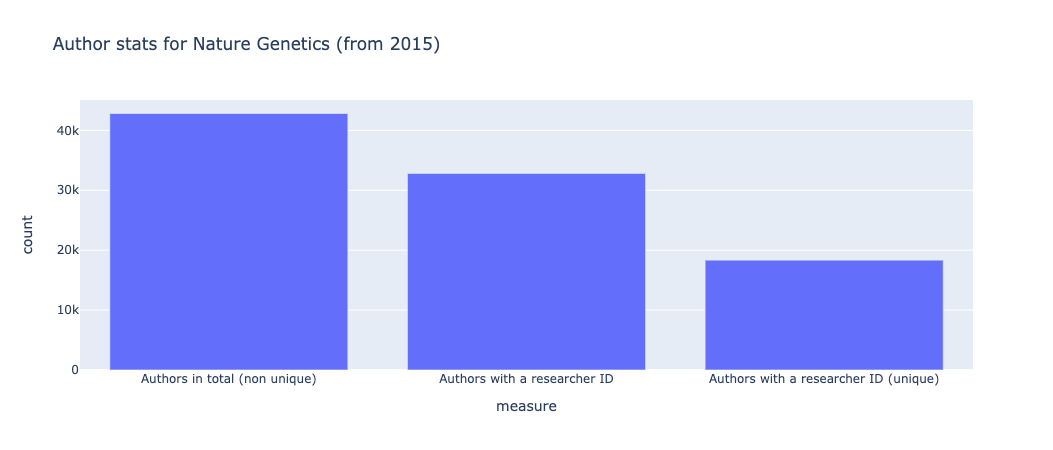

In [6]:
researchers = authors.query("researcher_id!=''")
#
df = pd.DataFrame({
    'measure' : ['Authors in total (non unique)', 'Authors with a researcher ID', 'Authors with a researcher ID (unique)'],
    'count' : [len(authors), len(researchers), researchers['researcher_id'].nunique()],
})
px.bar(df, x="measure", y="count", title=f"Author stats for {journal_title} (from {start_year})")

In [7]:
# save the researchers data to a file
researchers.to_csv("data/1.authors_with_researchers_id.csv")

## Apprendix: A quick look at authors *without a Researcher ID*

We're not going to try to disambiguate them here, but still it's good to have a quick look at them... 

Looks like the most common surname is `Wang`, while the most common first name is an empty value

In [8]:
authors_without_id = authors.query("researcher_id==''")
authors_without_id[['first_name', 'last_name']].describe()


,first_name,last_name
count,10003,10003
unique,4366,4305
top,,
freq,544,382


Top Ten surnames seem all Chinese.. 

In [9]:
authors_without_id['last_name'].value_counts()[:10]

         382
Wang     178
Zhang    145
Li       143
Liu      129
Chen     106
Yang      69
Zhao      60
Lee       58
Kim       50
Name: last_name, dtype: int64

### Any common patterns? 

If we try to group the data by name+surname we can see some interesting patterns 

* some entries are things which are not persons (presumably the results of bad source data in Dimensions, eg from the publisher) 
* there are some apparently meaningful name+surname combinations with a lot of hits
* not many Chinese names in the top ones 



In [10]:
test = authors_without_id.groupby(["first_name", "last_name"]).size()
test.sort_values(ascending=False, inplace=True)
test.head(50)

first_name    last_name   
                              382
Jaakko        Tuomilehto       13
James G.      Wilson           12
M. Arfan      Ikram            12
Wei           Zhao             12
Olle          Melander         11
James P.      Cook             11
Jouke-Jan     Hottenga         10
Brooke        LaFlamme         10
Qiong         Yang             10
Jie           Huang            10
Aarno         Palotie          10
Tõnu          Esko              9
Kari          Stefansson        9
Andre         Franke            9
Najaf         Amin              9
Andrew P.     Morris            9
Christian     Gieger            9
Daniela       Toniolo           9
Lars          Lind              9
Ying          Wu                9
Wolfgang      Lieb              9
Joanna M. M.  Howson            9
Ganesh        Chauhan           8
Weihua        Zhang             8
André G.      Uitterlinden      8
Grant W.      Montgomery        8
Charles       Kooperberg        8
Nicholas G.   Martin 

## Conclusion and next steps

For the next tasks, we will focus on the disambiguated authors as the Researcher ID links will let us carry out useful analyses.

Still, we can **save the authors with missing IDs** results and try to do some manual disambiguation later. To this end, adding a simple google-search URL can help in making sense of these data quickly.

In [11]:
from urllib.parse import quote

out = []
for index, value in test.items():
    # compose a simple URL of the form 'https://www.google.com/search?q=tonu+esko'
    if index[0] or index[1]:
        n, s = quote(index[0]), quote(index[1])
        url = f"https://www.google.com/search?q={n}+{s}"
    else:
        url = ""
    d = {'name': index[0] , 'surname' : index[1] , 'frequency' : value , 'search_url' : url }
    out.append(d)

dftest = pd.DataFrame.from_dict(out)
# set order of columns
dftest = dftest[['name', 'surname', 'frequency', 'search_url']]

dftest.head(20)

,name,surname,frequency,search_url
0,,,382,
1,Jaakko,Tuomilehto,13,https://www.google.com/search?q=Jaakko+Tuomilehto
2,James G.,Wilson,12,https://www.google.com/search?q=James%20G.+Wilson
3,M. Arfan,Ikram,12,https://www.google.com/search?q=M.%20Arfan+Ikram
4,Wei,Zhao,12,https://www.google.com/search?q=Wei+Zhao
5,Olle,Melander,11,https://www.google.com/search?q=Olle+Melander
6,James P.,Cook,11,https://www.google.com/search?q=James%20P.+Cook
7,Jouke-Jan,Hottenga,10,https://www.google.com/search?q=Jouke-Jan+Hott...
8,Brooke,LaFlamme,10,https://www.google.com/search?q=Brooke+LaFlamme
9,Qiong,Yang,10,https://www.google.com/search?q=Qiong+Yang


In [12]:
# save the data
#
dftest.to_csv("data/1.authors_not_disambiguated_frequency.csv", header=True)

In [13]:
if COLAB_ENV:
  files.download("data/1.authors_not_disambiguated_frequency.csv")
  files.download("data/1.authors_with_researchers_id.csv")
  files.download("data/1.publications_authors.csv")
  files.download("data/1.publications_authors_affiliations.csv")
  files.download("data/1.pubs_metadata_with_metrics.csv")

That's it! 

Now let's go and open this in [Google Sheets](https://docs.google.com/spreadsheets/)...